In [1]:
# !pip install -q --user albumentations
# !pip3 install pydicom

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import torch.optim as optim
import time
import ipywidgets as widgets
import pickle


# 導入dicom套件
from pydicom import dcmread
from pydicom.data import get_testdata_files

In [4]:
from utils.dataset import getAllDataPath, CustomImageDataset, show_image
from utils.unet import UNet, ResUnet, AttUnet
from utils.loss import DiceLoss, FocalLoss

In [5]:
BATCH_SIZE = 8
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [6]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([                       
    A.Resize(WIDTH, HEIGHT),
])

## 資料整理與處理

In [7]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_nlb_data = getAllDataPath(root, test_split_size=None, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_nlb_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform, pseudo_label=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform, pseudo_label=False) 
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

dataset_nlb_train = CustomImageDataset(MRI_nlb_data['train'], transform=transform, pseudo_label=False)
dataloader_nlb_train = torch.utils.data.DataLoader(dataset_nlb_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform, pseudo_label=False)
CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_data train (1360, 2)
CT_data test (341, 2)
MRI_data train (370, 2)
MRI_data test (93, 2)


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([30626,  1337,   878,   612,  7046, 22947,  1721,   229,   125,
          15]), array([0.        , 0.09931276, 0.19862552, 0.2979383 , 0.39725104,
       0.4965638 , 0.5958766 , 0.6951893 , 0.7945021 , 0.8938148 ,
       0.9931276 ], dtype=float32)) tensor([0., 1.])


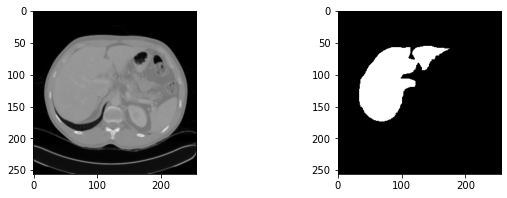

In [8]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in CT_dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
    
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())
        break
    break

## Type 1: unet domain confusion
> 對unet的輸出做domain confusion

In [9]:
class conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.cell=nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, 1, 1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
    def forward(self,x):
        return self.cell(x)
    
class DomainClassifier(nn.Module): # input B, 1024, 16*16
    def __init__(self,ch_in=1):
        super().__init__()
        ftrs_ch = 32
        self.blocks = nn.Sequential(
          conv(ch_in,ftrs_ch),
          nn.AdaptiveAvgPool2d((1,1))
        )
        self.output = nn.Sequential(
          nn.Flatten(),
          nn.Linear(ftrs_ch, 128),
          nn.ReLU(),
          nn.Linear(128, 1), 
        )
        
    def forward(self, x):
        x = self.blocks(x)
        x = self.output(x)
        return x

In [10]:
'''
title: create model
---
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面(也就是在把參數託管給optim以前)
ref: 
- https://pytorch.org/docs/stable/optim.html 
- Road Extraction by Deep Residual U-Net, 2017
- U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015
- Attention U-Net: Learning Where to Look for the Pancreas, 2018
'''
 
model = UNet
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)
domain_classifier = DomainClassifier().to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-1)
optimizer_disc = optim.Adam(domain_classifier.parameters(), lr = 1e-1)

domain_criterion = nn.BCEWithLogitsLoss()
class_criterion = DiceLoss()

In [11]:
'''
abs: training model
---
- 下面的程序會在3種條件下儲存當前的model(只包含weight)
    - 當前模型的loss是目前以來最低
    - 當前epoch數是20的倍數
    - 完成一個epoch的訓練
'''
from torchvision.ops import sigmoid_focal_loss
EPOCHS = 1
DISC_LOOPS = 2
lamb = 0.1
min_target_loss_value = float("inf") 
save_root = './data/save_weights/'
os.makedirs(save_root, exist_ok=True)

In [13]:
for epoch in range(EPOCHS):  
    class_loss_value = 0.0
    if epoch < 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
    elif epoch == 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-2
    
    running_D_loss = 0.0
    class_loss_value = 0.0
            
    for i, ((source_data, source_label), (target_data, target_label)) in enumerate(zip(CT_dataloader_train, dataloader_train)):
        # zero the parameter gradients
        '''
        abs: zero the parameter gradients
        ---
        這兩種方法都能夠清除variable內的gradient:
        方法1
        param in model.parameters():
        param.grad = None
        方法2 借助optimizer尋找關聯的variable並清除gradient
        optimizer.zero_grad()
        '''
        optimizer.zero_grad()
        optimizer_disc.zero_grad()

        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        target_label = target_label.to(device)
        
        # 我們把source data和target data混在一起，讓normalization標準一致
        mixed_data = torch.cat([source_data, target_data], dim=0)
        # 設定source data的domain label為1, target的為0
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).to(device)
        domain_label[:source_data.shape[0]] = 1
        
        domain_classifier.train()
        model.eval()
        
        with torch.no_grad():
            emb = model(mixed_data.detach())
            del mixed_data
        for _ in range(DISC_LOOPS):
            # 不需要訓練Feature Extractor，所以把feature detach避免loss backprop上去。
            domain_logits = domain_classifier(emb.detach()) # unet輸出層
            loss = domain_criterion(domain_logits, domain_label)
            running_D_loss += loss.item()
            loss.backward()
            optimizer_disc.step()
            optimizer_disc.zero_grad()
            del loss, domain_logits
            
        torch.cuda.empty_cache()
        model.train()
        domain_classifier.eval()
        
        '''
        計算domain fusing loss
        '''
        with torch.no_grad():
            domain_logits = domain_classifier(emb.detach()) # unet最底下的embedding
        loss_disc = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss_disc.item()
        
        del emb, domain_logits, domain_label
        torch.cuda.empty_cache()
        
        '''
        計算特徵萃取器的loss
        '''
        outputs = model(source_data)
        outputs = F.sigmoid(outputs)
        loss = class_criterion(outputs, source_label) + 0.5*lamb*loss_disc
        loss.backward(retain_graph=True)
        
        class_loss_value += loss.item()
        del source_data, source_label, outputs, loss
        torch.cuda.empty_cache()
        
        outputs = model(target_data)
        outputs = F.sigmoid(outputs)
        loss = class_criterion(outputs, target_label) + 0.5*lamb*loss_disc
        loss.backward()
        class_loss_value += loss.item()
        del target_data, target_label, outputs, loss, loss_disc
        torch.cuda.empty_cache()
        
        
        optimizer.step()
        optimizer.zero_grad()
        print(i, end='\r')
            

    class_loss_value /= (i+1)   
    running_D_loss /= (i+1)
    testing_loss_value = class_loss_value

    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}, running_D_loss:{running_D_loss}')
    if testing_loss_value < min_target_loss_value:
        min_target_loss_value = testing_loss_value
        print('save best model')
        torch.save(model.state_dict(), f'{save_root}best_model.bin')
    else:
        if epoch%50==49:
            
            torch.save(model.state_dict(), f'{save_root}E{epoch}_model.bin')
        torch.save(model.state_dict(), f'{save_root}model.bin')
    

epoch: 0, class_loss_value:1.7811605114003886, running_D_loss:1.2204294719292945
save best model


## 測試模型

### load model

In [12]:
device = 'cuda:0'

In [13]:
model = UNet
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=1, activation=None).to(device)
model.load_state_dict(torch.load(f'{save_root}best_model.bin')) # load state

<All keys matched successfully>

In [14]:
dic = dict(zip(
    ['dataloader_train', 'dataloader_test', 'CT_dataloader_train', 'CT_dataloader_test'],
    [dataloader_train, dataloader_test, CT_dataloader_train, CT_dataloader_test]
))

w = widgets.ToggleButtons(
    options=['CT_dataloader_train', 'CT_dataloader_test', 'dataloader_train', 'dataloader_test', ],
    description='Testing DataSet',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

display(w)


ToggleButtons(description='Testing DataSet', options=('CT_dataloader_train', 'CT_dataloader_test', 'dataloader…

### testing

CT_dataloader_train
8
tensor(0.9904, device='cuda:0')
torch.Size([8, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


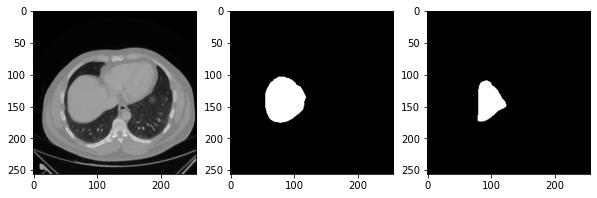

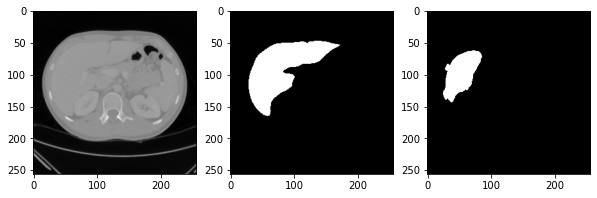

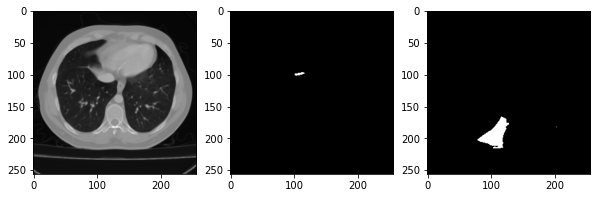

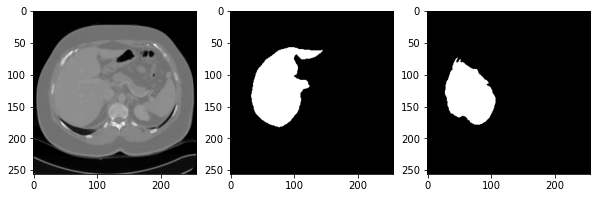

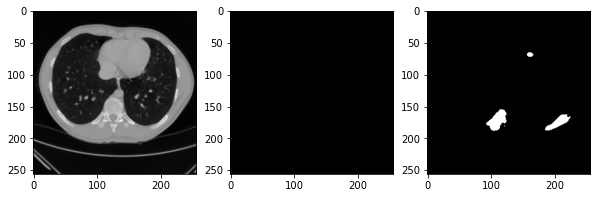

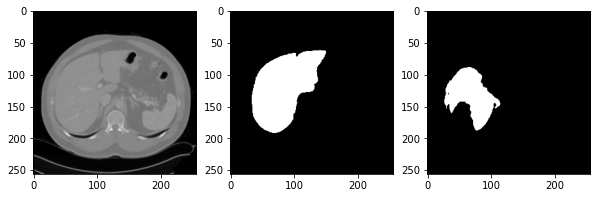

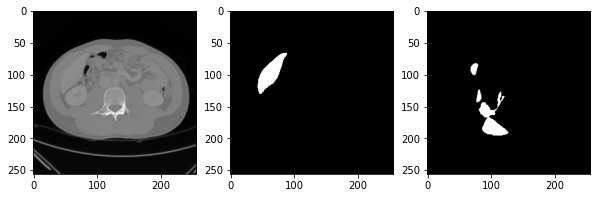

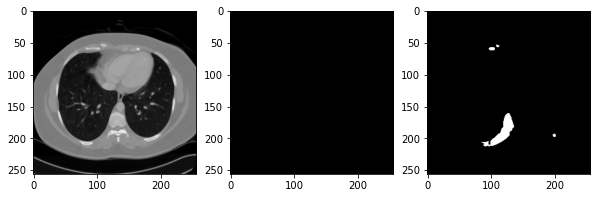

In [18]:
#@title [Colab Form] 測試不同的dataloader 
#@markdown 可能的選擇包括 'dataloader_train', 'dataloader_test', 'CT_dataloader_test'
print(w.value)
test_dataloader = dic[w.value]


def test():
    with torch.no_grad(): # 避免torch計算gradient產生記憶體負擔
        for i, data in enumerate(test_dataloader, 1): 
            torch.cuda.empty_cache()
            image, mask = data
            print(len(image))

            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = class_criterion(outputs, mask)
            print(loss)

            '''
            設定閥值輸出:
            其實不設定也是可以輸出，不設定的情況會用灰階輸出，不過想要分割得很漂亮可以用閥值處理一下
            '''
            if True: # 可以改成false，採灰階輸出， True的話會通過閾值輸出
                thres = 0
                outputs[outputs<thres] = 0 
                outputs[outputs!=0] = 1
                outputs = outputs.long()

            print(image[:,0,:,:].shape)
            print(mask.shape)
            print(outputs.shape)

            img_process = lambda image:image[:,0,:,:].detach().cpu().numpy()
            mask_process = lambda mask:mask.squeeze(1).detach().cpu().numpy()

            for x, m, p in [*zip(img_process(image), mask_process(mask), mask_process(outputs))]:
                  # show_image_mask(x, m, p)
                show_image(x,m,p)

            del image, mask, outputs, data, loss # 把記憶體清掉
            torch.cuda.empty_cache()
            break
  
    
tmp = test()